In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import torch
from torch import nn

from hparams.light46_hparams import create_hparams
from model import Model
from datasets import LJDataset, TextMelCollate
from utils import sizeof_fmt, Logger

In [2]:
!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="0"

Mon Mar  8 19:58:35 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.04    Driver Version: 455.23.04    CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 3090    Off  | 00000000:19:00.0 Off |                  N/A |
| 67%   59C    P2   198W / 370W |   8157MiB / 24268MiB |     27%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 3090    Off  | 00000000:68:00.0 Off |                  N/A |
| 56%   

In [3]:
save_dir = 'save/light46_model'
logger = Logger(save_dir=save_dir, new=False)
print('done')

done


In [4]:
!ls $save_dir

data.json  save_0


In [5]:
stt_hparams, tts_hparams = create_hparams()
model = Model(stt_hparams, tts_hparams)
model = model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=tts_hparams.lr, weight_decay=tts_hparams.weight_decay)

step = 0

size = sizeof_fmt(4 * sum(p.numel() for p in model.parameters()))
print(f"Model size {size}")

size = sizeof_fmt(4 * sum(p.numel() for p in model.tts.parameters()))
print(f"TTS size {size}")

size = sizeof_fmt(4 * sum(p.numel() for p in model.tts.mel_encoder.parameters()))
print(f"MelEncoder size {size}")

size = sizeof_fmt(4 * sum(p.numel() for p in model.tts.mel_decoder.parameters()))
print(f"MelDecoder size {size}")

if False:
    model, optimizer, step = logger.load(step, model, optimizer)
print(step)

print('done')

Model size 162.6MiB
TTS size 156.2MiB
MelEncoder size 52.3MiB
MelDecoder size 94.9MiB
0
done


In [6]:
trainset = LJDataset(tts_hparams)
collate_fn = TextMelCollate(tts_hparams)
train_loader = torch.utils.data.DataLoader(trainset, num_workers=tts_hparams.num_workers, 
                          shuffle=True,
                          sampler=None,
                          batch_size=tts_hparams.batch_size, pin_memory=False,
                          drop_last=True, collate_fn=collate_fn)

print(train_loader)

In [7]:
def to_cuda(batch):
    batch['text'] = batch['text'].cuda()
    batch['text_lengths'] = batch['text_lengths'].cuda()
    batch['mels'] = batch['mels'].cuda()
    batch['mel_lengths'] = batch['mel_lengths'].cuda()
    
    return batch

elapsed time : 0.0348679780960083


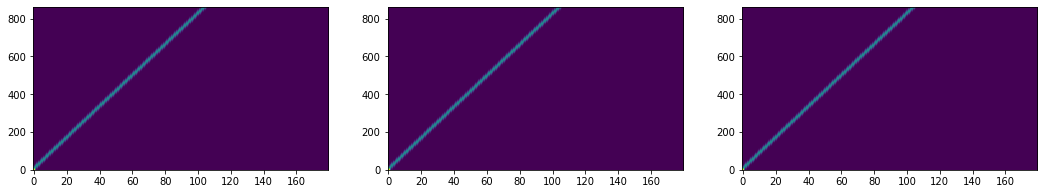

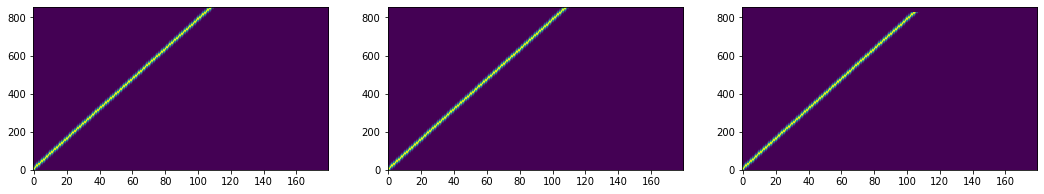

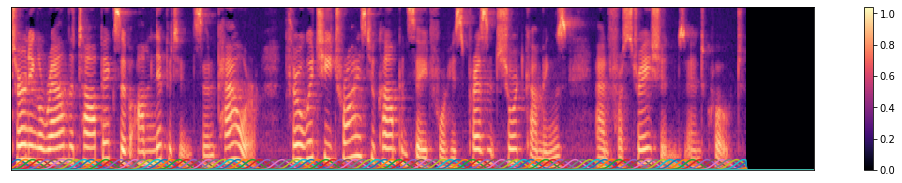

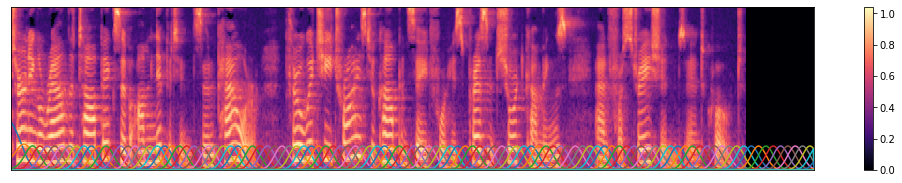

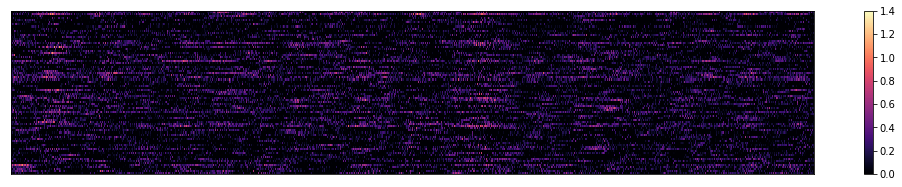

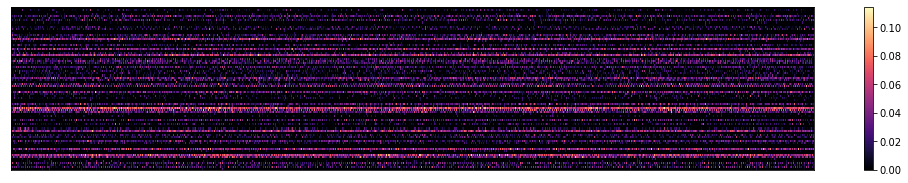

tensor(0.8412, device='cuda:0')
step : 1 stt : 5.5064 tts : 2.4338 recon : 0.2059 kl : 0.0619 beta : 0.0000
tensor(0.7726, device='cuda:0')
step : 2 stt : 5.4949 tts : 2.4131 recon : 0.1410 kl : 0.0691 beta : 0.0001
tensor(0.7277, device='cuda:0')
step : 3 stt : 5.4889 tts : 2.2801 recon : 0.1233 kl : 0.0853 beta : 0.0001
tensor(70.1759, device='cuda:0')
step : 4 stt : 5.4784 tts : 2.2322 recon : 0.1287 kl : 0.8504 beta : 0.0001
tensor(0.7542, device='cuda:0')
step : 5 stt : 5.4707 tts : 2.2416 recon : 0.0852 kl : 0.1146 beta : 0.0001
tensor(0.7230, device='cuda:0')
step : 6 stt : 5.4662 tts : 2.2337 recon : 0.0777 kl : 0.1035 beta : 0.0001
tensor(0.7159, device='cuda:0')
step : 7 stt : 5.4511 tts : 2.0681 recon : 0.0644 kl : 0.1087 beta : 0.0002
tensor(0.7622, device='cuda:0')
step : 8 stt : 5.4408 tts : 2.3361 recon : 0.0658 kl : 0.1166 beta : 0.0002
tensor(0.7001, device='cuda:0')
step : 9 stt : 5.4314 tts : 2.1816 recon : 0.0534 kl : 0.1216 beta : 0.0002
tensor(0.7374, device='cuda

In [ ]:
from IPython import display
import matplotlib.pyplot as plt
import librosa.display
import numpy as np
import time

model.train()

while(True):
    
    for batch in train_loader:
        batch = to_cuda(batch)
        
        model.train()
        model.increase_step()
        model.zero_grad()

        stt_outputs, tts_outputs = model(batch)
        loss = tts_outputs['loss'] + stt_outputs['loss']
        loss.backward()
        
        grad_norm = nn.utils.clip_grad_norm_(model.parameters(), 1)
        print(grad_norm.mean())
        if torch.isnan(grad_norm.mean()):
            continue
        
        optimizer.step()
        
        if step % 5000 == 0:
            logger.save(step, model, optimizer)
        
        if step % 1 == 0:
            print('step :', step, 
                  'stt :', '%0.4f' % stt_outputs['loss'].item(),
                  'tts :', '%0.4f' % tts_outputs['loss'].item(),
                  'recon :', '%0.4f' % tts_outputs['recon_loss'].item(),
                  'kl :', '%0.4f' % tts_outputs['kl_loss'].item(),
                  'beta :', '%0.4f' % model.beta.item())
                  
            
        if step % 100 == 0:
            logger.log(step, 'stt_loss', stt_outputs['loss'].item())
            logger.log(step, 'tts_loss', tts_outputs['loss'].item())    
            logger.log(step, 'recon_loss', tts_outputs['recon_loss'].item())    
            logger.log(step, 'kl_loss', tts_outputs['kl_loss'].item())    
            logger.log(step, 'beta', model.beta.item())    
            
        if step % 100 == 0:
            display.clear_output()
            
            index = 3
            model.eval()
            
            with torch.no_grad():
                times = []
                for _ in range(10):
                    t0 = time.time()
                    samples, _ = model.inference(batch['text'], batch['mels'].size(2), tts_outputs["stt_alignments"], temperature=1.0)
                    t1 = time.time()
                    times.append(t1 - t0)
                times = np.array(times)
                print('elapsed time :', np.mean(times))

            _tts_alignments = tts_outputs["alignments"].data.cpu().numpy()
            batch_size = _tts_alignments.shape[0]
            plt.figure(figsize=[18, 3])
            for i in range(3):
                plt.subplot(1, 3, i+1)
                plt.imshow(_tts_alignments[i].T, aspect='auto', origin='lower', interpolation='none')
            plt.show()
            
            _stt_alignments = stt_outputs["alignments"].data.cpu().numpy()
            batch_size = _stt_alignments.shape[0]
            plt.figure(figsize=[18, 3])
            for i in range(3):
                plt.subplot(1, 3, i+1)
                plt.imshow(_stt_alignments[i].T, aspect='auto', origin='lower', interpolation='none')
            plt.show()
            
            plt.figure(figsize=[18, 3])
            _x = batch['mels'].data.cpu().numpy()
            librosa.display.specshow(_x[index])
            plt.colorbar()
            
            for i in range(_stt_alignments.shape[1]):
                plt.plot(_stt_alignments[index, i] * 100)
                
            plt.show()
            
            _stt_alignments = tts_outputs["stt_alignments"].data.cpu().numpy()
            plt.figure(figsize=[18, 3])
            _x = batch['mels'].data.cpu().numpy()
            librosa.display.specshow(_x[index])
            plt.colorbar()
            
            for i in range(_stt_alignments.shape[1]):
                plt.plot(_stt_alignments[index, i] * 30)
                
            plt.show()
            
            plt.figure(figsize=[18, 3])
            _y = tts_outputs['pred'].data.cpu().numpy()
            librosa.display.specshow(np.maximum(_y[index], 0))
            plt.colorbar()
            plt.show()
            
            plt.figure(figsize=[18, 3])
            _s = samples.data.cpu().numpy()
            librosa.display.specshow(np.maximum(_s[index, :, :_y.shape[2]], 0))
            plt.colorbar()
            plt.show()
                      
        step += 1
        

In [ ]:
logger.save(step, model, optimizer)

In [ ]:
import matplotlib.pyplot as plt
import librosa.display
import numpy as np
import time 

for batch in train_loader:
    batch = to_cuda(batch)
    print(batch['strings'])
    break
        
model.eval()
with torch.no_grad():
    index = 0
    times = []
    for _ in range(10):
        t0 = time.time()
        samples, time_dict = model.inference(batch['text'][0:1], None, None, temperature=1.0)
        t1 = time.time()
        times.append(t1 - t0)
    times = np.array(times)
    print(samples.shape, np.mean(times))
    print(time_dict)
    
    plt.figure(figsize=[18, 3])
    _s = samples.data.cpu().numpy()
    librosa.display.specshow(_s[index])
    plt.colorbar()
    plt.show()

In [ ]:
time_sum = 0
for key in time_dict.keys():
    time_sum += time_dict[key]

for key in time_dict.keys():
    print(key, '%0.2f' % (time_dict[key] / time_sum))


In [ ]:
def denormalize(x):
    return np.exp(x * -np.log(1e-5) + np.log(1e-5))

import time

mel_matrix = librosa.filters.mel(sr=22050, n_fft=1024, n_mels=80, fmin=80, fmax=7600)
inv_matrix = np.linalg.pinv(mel_matrix)

mel = denormalize(_s[0])
spec = inv_matrix @ mel

librosa.display.specshow(spec)
plt.colorbar()
plt.show()

audio = librosa.griffinlim(spec, n_iter=32, hop_length=256, win_length=None, window='hann')
import IPython.display as ipd
ipd.Audio(audio, rate=22050)